In [1]:
import mne
from mne.channels import make_standard_montage

In [2]:
mne.set_log_level('WARNING')


In [3]:
!pip install mne_icalabel

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

try:
    import PyQt5.QtCore
    %matplotlib qt
except ImportError:
    %matplotlib inline'
import pandas as pd
import scipy.io
import os
import mne
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [5]:
from mne.datasets import eegbci

# Select subjects
subjects = range(1, 2)

# Select runs
runs = [2, 3, 7]  # motor imagery 
raw_fnames = []
for subject in subjects:
    raw_fnames += eegbci.load_data(subject, runs)

C:\ProgramData\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [6]:
raw_fnames

['C:\\Users\\Patrick\\mne_data\\MNE-eegbci-data\\files\\eegmmidb\\1.0.0\\S001\\S001R02.edf',
 'C:\\Users\\Patrick\\mne_data\\MNE-eegbci-data\\files\\eegmmidb\\1.0.0\\S001\\S001R03.edf',
 'C:\\Users\\Patrick\\mne_data\\MNE-eegbci-data\\files\\eegmmidb\\1.0.0\\S001\\S001R07.edf']

In [7]:
from mne import concatenate_raws
from mne.io import read_raw_edf

# Load data
raw_baseline = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames if "R02" in f])
raw_fist=concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames if "R03" in f or "R07" in f])
# Clean up channel names
raw_baseline.rename_channels(lambda x: x.strip('.'))
raw_fist.rename_channels(lambda x: x.strip('.'))
# Data is stored as a numpy array
print(type(raw_baseline._data))

# Metadata for the recording is available as an info object
print(raw_baseline.info)

# Check sample rate
print('sample rate:', raw_baseline.info['sfreq'], 'Hz')

# Gives the size of the data matrix
print('channels x samples:', raw_baseline._data.shape)

<class 'numpy.ndarray'>
<Info | 7 non-empty values
 bads: []
 ch_names: Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>
sample rate: 160.0 Hz
channels x samples: (64, 9760)


In [8]:
# Data is stored as a numpy array
print(type(raw_fist._data))

# Metadata for the recording is available as an info object
print(raw_fist.info)

# Check sample rate
print('sample rate:', raw_fist.info['sfreq'], 'Hz')

# Gives the size of the data matrix
print('channels x samples:', raw_fist._data.shape)
eegbci.standardize(raw_baseline)
eegbci.standardize(raw_fist)
montage = make_standard_montage('standard_1005')
raw_baseline.set_montage(montage)
raw_fist.set_montage(montage)

<class 'numpy.ndarray'>
<Info | 7 non-empty values
 bads: []
 ch_names: Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>
sample rate: 160.0 Hz
channels x samples: (64, 40000)


<RawEDF | S001R03.edf, 64 x 40000 (250.0 s), ~19.6 MB, data loaded>

In [9]:

# Apply band-pass filter
raw_baseline.filter(7., 35., fir_design='firwin')
raw_fist.filter(7., 35., fir_design='firwin')


<RawEDF | S001R03.edf, 64 x 40000 (250.0 s), ~19.6 MB, data loaded>

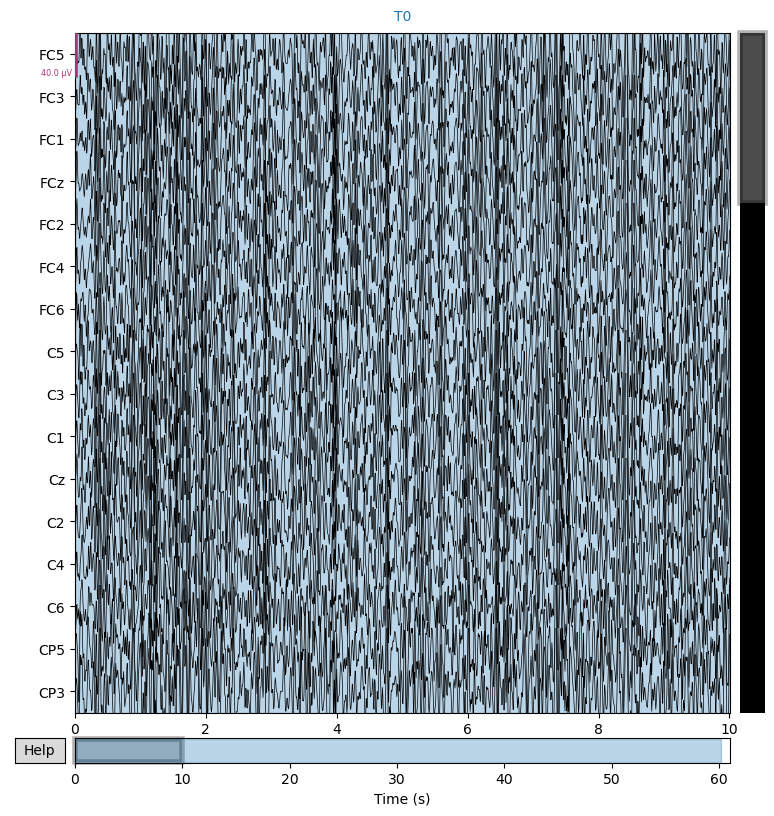

In [10]:
raw_baseline.plot(n_channels=16)

In [11]:
raw_baseline.plot(start=1,duration=1,n_channels=16)
raw_fist.plot(start=1,duration=1,n_channels=16)

from mne_icalabel import label_components


def apply_automated_ica(raw_obj):
    ica = mne.preprocessing.ICA(n_components=21, random_state=36, method="infomax", fit_params=dict(extended=True))
    ica.fit(raw_obj)
    ic_labels = label_components(raw_obj, ica, method="iclabel")
    labels = ic_labels["labels"]
    exclude_idx = [
        idx for idx, label in enumerate(labels) if label not in ["brain", "other"]
    ]
    print(f"Excluding these ICA components: {exclude_idx}")
    reconst_raw = raw_obj.copy()
    ica.apply(reconst_raw, exclude=exclude_idx)
    return reconst_raw


In [12]:
raw_baseline=apply_automated_ica(raw_baseline)
raw_fist=apply_automated_ica(raw_fist)

C:\Users\Patrick\AppData\Local\Temp\ipykernel_11064\1625123011.py:10: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_obj, ica, method="iclabel")
C:\Users\Patrick\AppData\Local\Temp\ipykernel_11064\1625123011.py:10: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_obj, ica, method="iclabel")


Excluding these ICA components: [2, 4, 5, 8, 13, 15, 16, 17, 18, 19, 20]


C:\Users\Patrick\AppData\Local\Temp\ipykernel_11064\1625123011.py:10: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_obj, ica, method="iclabel")
C:\Users\Patrick\AppData\Local\Temp\ipykernel_11064\1625123011.py:10: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_obj, ica, method="iclabel")


Excluding these ICA components: [0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20]


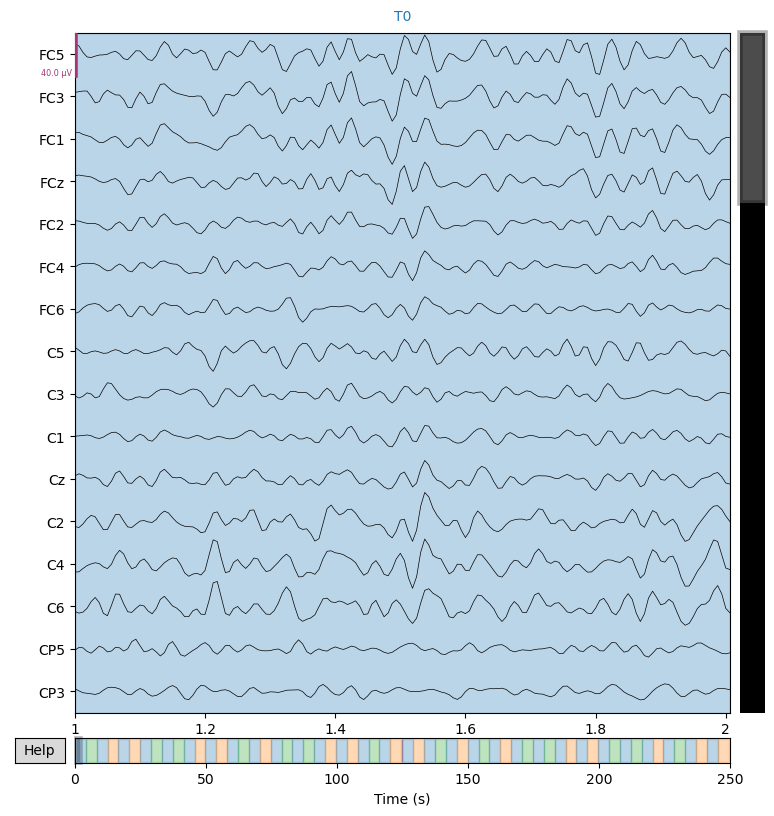

In [13]:
raw_baseline.plot(start=1,duration=1,n_channels=16)
raw_fist.plot(start=1,duration=1,n_channels=16)

In [14]:
from mne import pick_types

# Select EEG channels
picks_base = pick_types(raw_baseline.info,
                   meg=False,
                   eeg=True,
                   stim=False,
                   eog=False,
                   exclude='bads')
# Select EEG channels
picks_fist = pick_types(raw_fist.info,
                   meg=False,
                   eeg=True,
                   stim=False,
                   eog=False,
                   exclude='bads')

# Subsample electrodes (odd-numbered channels only)
picks_fist = picks_fist[::2]
picks_base=picks_base[::2]

In [15]:
from mne import Epochs, events_from_annotations

# Avoid classification of evoked responses by using epochs that start 1s after cue onset
tmin, tmax = 1., 2.
event_id=dict(left=2, right=3)

# Get events from an Annotations object.
events, _ = events_from_annotations(raw_fist, event_id=dict(T1=2, T2=3))
print('Found {} events'.format(events.shape[0]))

# Read epochs
epochs = Epochs(raw_fist,
                events,
                event_id,
                tmin,
                tmax,
                proj=True,
                picks=picks_fist,
                baseline=None,
                preload=True)

# Inspect epochs
print(epochs.info)
print('events x channels x samples:', epochs._data.shape)

# Get labels
labels = epochs.events[:, -1] - 2

Found 30 events
<Info | 8 non-empty values
 bads: []
 ch_names: FC5, FC1, FC2, FC6, C3, Cz, C4, CP5, CP1, CP2, CP6, Fpz, AF7, ...
 chs: 32 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 7.0 Hz
 lowpass: 35.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 32
 projs: []
 sfreq: 160.0 Hz
>
events x channels x samples: (30, 32, 161)


In [16]:
from mne import Epochs, events_from_annotations

# Avoid classification of evoked responses by using epochs that start 1s after cue onset
tmin, tmax = 0., 60.
event_id=dict(nothing=0)

# Get events from an Annotations object.
events, _ = events_from_annotations(raw_baseline, event_id=dict(T0=0))
print('Found {} events'.format(events.shape[0]))

# Read epochs
epochs_basline = Epochs(raw_baseline,
                events,
                event_id,
                tmin,
                tmax,
                proj=True,
                picks=picks_base,
                baseline=None,
                preload=True)

# Inspect epochs
print(epochs_basline.info)
print('events x channels x samples:', epochs_basline._data.shape)

# Get labels
labels_baseline = epochs_basline.events[:, -1] - 2

Found 1 events
<Info | 8 non-empty values
 bads: []
 ch_names: FC5, FC1, FC2, FC6, C3, Cz, C4, CP5, CP1, CP2, CP6, Fpz, AF7, ...
 chs: 32 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 7.0 Hz
 lowpass: 35.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 32
 projs: []
 sfreq: 160.0 Hz
>
events x channels x samples: (1, 32, 9601)


In [17]:
epochs_data_baseline = 1e6 * epochs_basline.get_data()
epochs_data_fist=1e6 *epochs.get_data()

In [18]:
print(epochs_data_baseline[0].shape)
print(epochs_data_fist[0].shape)

(32, 9601)
(32, 161)


In [19]:
data_baseline=np.swapaxes(epochs_data_baseline[0],0,1)

In [20]:
data_baseline.shape

(9601, 32)

In [21]:
all_b=[]
for i,v in enumerate(data_baseline):
    if i+161>=len(data_baseline):
        break
    all_b.append(data_baseline[i:i+161])

In [22]:
all_b=np.array(all_b)

In [23]:
all_b=np.swapaxes(all_b,2,1)

In [24]:
all_b.shape

(9440, 32, 161)

In [54]:
np.mean(all_b)

0.00045013043994528607

In [55]:
np.mean(epochs_data_fist)

-0.002703686710722808

In [49]:
from sklearn.preprocessing import MinMaxScaler
all_b
epochs_data_fist
scaler = MinMaxScaler()
scaler.fit(all_b)
all_b = scaler.transform(all_b)
epochs_data_fist=scaler.transform(epochs_data_fist)

ValueError: Found array with dim 3. MinMaxScaler expected <= 2.

In [74]:
all_b_train=all_b[:9000]
all_b_test=all_b[9000:]
all_b_train.shape
''
from tensorflow.keras import layers
layer = layers.Normalization()
layer1 = layers.Normalization()
layer.adapt(all_b_train.astype(float))
layer1.adapt(epochs_data_fist.astype(float))
print(all_b_train)
print(np.max(layer(all_b_train)))
print(np.max(layer(epochs_data_fist)))

[[[-1.19465049e-03 -1.45804911e+01 -1.81856702e+01 ...  2.98051127e+01
    3.20402252e+01  2.33888959e+01]
  [ 2.38232095e-03 -1.30588960e+01 -1.75596436e+01 ...  3.65399713e+01
    4.54115859e+01  4.49564572e+01]
  [ 3.37098680e-03 -1.55442121e+01 -1.88898158e+01 ...  4.20769586e+01
    5.21142851e+01  5.36146811e+01]
  ...
  [-2.04255050e-03  2.38534563e+00 -2.56892168e+00 ...  1.61050601e+00
    1.84272405e+01  3.82926658e+01]
  [-4.20677276e-03  3.88789667e+01  4.88610365e+01 ... -3.16202082e+01
    1.14635194e+01  5.57974020e+01]
  [-3.96192311e-03  2.71353312e+01  3.08775863e+01 ... -9.83768335e+00
    4.61654147e+00  1.79263353e+01]]

 [[-1.45804911e+01 -1.81856702e+01 -7.95830361e+00 ...  3.20402252e+01
    2.33888959e+01  1.39217705e+01]
  [-1.30588960e+01 -1.75596436e+01 -7.66862709e+00 ...  4.54115859e+01
    4.49564572e+01  3.20875162e+01]
  [-1.55442121e+01 -1.88898158e+01 -6.11545420e+00 ...  5.21142851e+01
    5.36146811e+01  4.03316599e+01]
  ...
  [ 2.38534563e+00 -2.5

In [61]:
latent_dim = 512 
keras.backend.clear_session()
class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(64, activation='gelu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(32*161, activation='linear'),
      layers.Reshape((32, 161))
    ])
    self.normal=tf.keras.layers.LayerNormalization()
  def call(self, x):
    #x = tf.divide(tf.subtract(x, tf.reduce_min(x)), tf.subtract(tf.reduce_max(x), tf.reduce_min(x)))
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [62]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=opt, loss=losses.MeanSquaredError())
autoencoder.fit(layer(all_b_train),layer(all_b_train),
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(layer(all_b_test), layer(all_b_test)))

Epoch 1/200
71/71 [==============================] - 1s 5ms/step - loss: 0.9621 - val_loss: 0.8357
Epoch 2/200
71/71 [==============================] - 0s 4ms/step - loss: 0.7657 - val_loss: 0.6929
Epoch 3/200
71/71 [==============================] - 0s 4ms/step - loss: 0.6364 - val_loss: 0.6073
Epoch 4/200
71/71 [==============================] - 0s 4ms/step - loss: 0.5732 - val_loss: 0.5566
Epoch 5/200
71/71 [==============================] - 0s 5ms/step - loss: 0.5291 - val_loss: 0.5130
Epoch 6/200
71/71 [==============================] - 0s 5ms/step - loss: 0.4935 - val_loss: 0.4748
Epoch 7/200
71/71 [==============================] - 0s 5ms/step - loss: 0.4636 - val_loss: 0.4420
Epoch 8/200
71/71 [==============================] - 0s 5ms/step - loss: 0.4377 - val_loss: 0.4162
Epoch 9/200
71/71 [==============================] - 0s 5ms/step - loss: 0.4158 - val_loss: 0.3953
Epoch 10/200
71/71 [==============================] - 0s 5ms/step - loss: 0.3972 - val_loss: 0.3799
Epoch 11/

71/71 [==============================] - 0s 6ms/step - loss: 0.2603 - val_loss: 0.2667
Epoch 84/200
71/71 [==============================] - 0s 6ms/step - loss: 0.2601 - val_loss: 0.2666
Epoch 85/200
71/71 [==============================] - 0s 5ms/step - loss: 0.2598 - val_loss: 0.2664
Epoch 86/200
71/71 [==============================] - 0s 5ms/step - loss: 0.2595 - val_loss: 0.2660
Epoch 87/200
71/71 [==============================] - 0s 5ms/step - loss: 0.2593 - val_loss: 0.2657
Epoch 88/200
71/71 [==============================] - 0s 5ms/step - loss: 0.2591 - val_loss: 0.2656
Epoch 89/200
71/71 [==============================] - 0s 5ms/step - loss: 0.2588 - val_loss: 0.2651
Epoch 90/200
71/71 [==============================] - 0s 5ms/step - loss: 0.2586 - val_loss: 0.2650
Epoch 91/200
71/71 [==============================] - 0s 4ms/step - loss: 0.2584 - val_loss: 0.2649
Epoch 92/200
71/71 [==============================] - 0s 4ms/step - loss: 0.2581 - val_loss: 0.2648
Epoch 93/200


KeyboardInterrupt: 

In [67]:
err=[]
err2=[]
encoded = autoencoder.encoder(all_b_test).numpy()
decoded = autoencoder.decoder(encoded).numpy()
#print("Error:",(np.square(layer(i)-decoded)).mean())
err.append((np.square(layer(all_b_test)-autoencoder.call(layer(all_b_test))).mean()))
print("###################")
print(np.array(err).mean())
encoded = autoencoder.encoder(layer1(epochs_data_fist)).numpy()
decoded = autoencoder.decoder(encoded).numpy()
#print("Error:",(np.square(layer(j)-decoded)).mean())
err2.append((np.square(layer1(epochs_data_fist)-autoencoder.call(layer1(epochs_data_fist))).mean()))
print("##############")
print(np.array(err).mean())
print(np.array(err2).mean())

###################
0.25719935
##############
0.25719935
0.8070608


In [77]:
err=[]
err2=[]
for i in all_b_test[:10]:
    err.append((np.square(layer(i)-autoencoder.call(layer(i))).mean()))
print("###################")
for j in epochs_data_fist[:10]:
    err2.append((np.square(layer1(j)-autoencoder.call(layer1(j)))).mean())
print("##############")
print(np.array(err).mean())
print(np.array(err2).mean())
print(np.array(err))
print(np.array(err2))

###################
##############
0.26397586
0.7560804
[0.24121727 0.26371893 0.25576156 0.25983855 0.24601385 0.2479101
 0.27711135 0.27995324 0.28021535 0.2880185 ]
[0.59291416 0.9556051  0.75784475 0.7193512  0.8711535  0.63130087
 0.58283013 0.67916745 0.6933884  1.0772481 ]


100%